In [129]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split  # Import train_test_split for data splitting
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os  # Import the os module
from scipy import stats  # Importing stats for statistical tests
from sklearn.model_selection import KFold

# Define columns for preprocessing the original dataset
categorical_columns = ['age', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'glucose_test', 'A1Ctest', 'change', 'diabetes_med']
numerical_columns = ['time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a custom Swish activation function class
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Define the Enhanced Neural Network model with choice of activation function
class EnhancedNeuralNetwork(nn.Module):
    def __init__(self, input_size, layers=50, activation='elu'):
        super(EnhancedNeuralNetwork, self).__init__()

        # Choose the activation function based on the input
        if activation == 'swish':
            self.activation = Swish()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(negative_slope=0.01)
        elif activation == 'elu':
            self.activation = nn.ELU(alpha=1.0)
        else:
            self.activation = nn.ReLU()

        # Create a list to hold the layers
        self.layers_list = nn.ModuleList()

        # Set the initial number of neurons
        num_neurons = input_size

        for i in range(layers):
            # Define the linear layer
            layer = nn.Linear(num_neurons, max(num_neurons // 2, 1))  # Ensure at least one neuron
            self.layers_list.append(layer)
            self.layers_list.append(nn.BatchNorm1d(max(num_neurons // 2, 1)))  # BatchNorm for the new size
            self.layers_list.append(self.activation)

            # Adding dropout with a decreasing rate
            dropout_rate = max(0.1, 0.2 - (i * (0.2 / layers)))
            self.layers_list.append(nn.Dropout(dropout_rate))

            num_neurons = max(num_neurons // 2, 1)  # Halve the number of neurons for the next layer but ensure at least one

        # Final output layer
        self.output = nn.Linear(max(num_neurons, 1), 2)  # Final layer should output two classes

        # Initialize weights using He Initialization
        self.initialize_weights()

    def forward(self, x):
        for layer in self.layers_list:
            x = layer(x)  # Apply each layer in sequence

        x = self.output(x)  # Output layer
        return x

    def initialize_weights(self):
        for layer in self.children():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                nn.init.constant_(layer.bias, 0)

In [118]:
def preprocess_data(data, categorical_columns, numerical_columns, encoder, scaler, test_size=0.2):
    """
    Preprocess the data and split into training and testing sets.

    Args:
    - data (DataFrame): The input data to preprocess.
    - categorical_columns (list): List of categorical column names.
    - numerical_columns (list): List of numerical column names.
    - encoder (OneHotEncoder): Fitted OneHotEncoder instance.
    - scaler (StandardScaler): Fitted StandardScaler instance.
    - test_size (float): Proportion of the dataset to include in the test split (default is 0.2).

    Returns:
    - X_train (ndarray): Training feature data.
    - X_test (ndarray): Testing feature data.
    - y_train (ndarray): Training labels.
    - y_test (ndarray): Testing labels.
    """
    # Encode categorical columns using the previously fitted OneHotEncoder
    encoded_categorical = encoder.transform(data[categorical_columns])

    # Standardize numerical columns using the previously fitted StandardScaler
    X_numerical = data[numerical_columns].values
    X_numerical_scaled = scaler.transform(X_numerical)

    # Combine numerical and categorical data
    X_combined = np.hstack((X_numerical_scaled, encoded_categorical))
    y_data = LabelEncoder().fit_transform(data['readmitted'])  # Ensure y_data is returned

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y_data, test_size=test_size, random_state=42)

    return X_train, X_test, y_train, y_test  # Return the training and testing datasets

In [119]:
def train_model(X_train, y_train, epochs=5, chunk_size=1000, learning_rate=0.005, activation='elu', layers=50, max_grad_norm=1.0, log = True):
    """
    Train the Enhanced Neural Network on the preprocessed training dataset.
    
    Args:
    - X_train (ndarray): Training feature data.
    - y_train (ndarray): Corresponding training labels.
    - epochs (int): Number of training epochs.
    - chunk_size (int): Size of data chunks for batch processing.
    - learning_rate (float): Learning rate for the optimizer.
    - activation (str): Activation function to use in the model.
    - max_grad_norm (float): Maximum norm for gradient clipping.
    
    Returns:
    - model: Trained Enhanced Neural Network model.
    """
    # Set up device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Define the neural network model
    input_size = X_train.shape[1]
    model = EnhancedNeuralNetwork(input_size=input_size, activation=activation, layers=layers).to(device)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-14)
    loss_function = nn.CrossEntropyLoss()

    # Training process
    for epoch in range(epochs):
        print(f"Starting Epoch {epoch + 1}")

        epoch_accuracies = []
        epoch_losses = []

        # Shuffle data at the start of each epoch
        indices = np.arange(len(X_train))
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]

        # Train in chunks
        for start_row in range(0, len(X_train), chunk_size):
            end_row = min(start_row + chunk_size, len(X_train))
            X_chunk = X_train[start_row:end_row]
            y_chunk = y_train[start_row:end_row]

            # Convert to PyTorch tensors
            X_tensor = torch.tensor(X_chunk, dtype=torch.float32).to(device)
            y_tensor = torch.tensor(y_chunk, dtype=torch.long).to(device)

            # Training step
            model.train()
            optimizer.zero_grad()
            outputs = model(X_tensor)
            loss = loss_function(outputs, y_tensor)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
            
            optimizer.step()

            # Evaluate model on current chunk
            model.eval()
            with torch.no_grad():
                predictions = model(X_tensor)
                _, predicted_labels = torch.max(predictions, 1)
                accuracy = accuracy_score(y_tensor.cpu(), predicted_labels.cpu())
                epoch_accuracies.append(accuracy)
                epoch_losses.append(loss.item())

        # Calculate overall accuracy and average loss for the epoch
        overall_epoch_accuracy = np.mean(epoch_accuracies)
        average_loss = np.mean(epoch_losses)
        if log:
            print(f"Overall Accuracy after Epoch {epoch + 1}: {overall_epoch_accuracy * 100:.2f}% - Average Loss: {average_loss:.4f}")

    return model

In [120]:
def test_model(model, X_test_data, y_test_data):
    """
    Evaluate the model on the specified test dataset.

    Args:
    - model: The trained neural network model instance.
    - X_test_data (ndarray): Testing feature data.
    - y_test_data (ndarray): Corresponding testing labels.

    Returns:
    - metrics (dict): Dictionary containing accuracy, confusion matrix, ROC AUC, and classification report.
    """
    # Set the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X_test_data, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y_test_data, dtype=torch.long).to(device)

    # Model predictions and probability extraction
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        _, predicted_labels = torch.max(outputs, 1)
        probabilities = nn.Softmax(dim=1)(outputs)[:, 1]  # Positive class probabilities

    # Convert predictions to numpy arrays and calculate evaluation metrics
    y_pred = predicted_labels.cpu().numpy()
    y_true = y_tensor.cpu().numpy()
    probabilities = probabilities.cpu().numpy()

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy on Test Dataset: {accuracy * 100:.2f}%")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, probabilities)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Classification Report
    report = classification_report(y_true, y_pred)
    print("Classification Report:")
    print(report)

    # Metrics dictionary
    metrics = {
        "Accuracy": accuracy,
        "Confusion Matrix": conf_matrix,
        "ROC AUC": roc_auc,
        "Classification Report": report
    }

    return metrics

/home/hlmilk/.local/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Starting Epoch 1
Overall Accuracy after Epoch 1: 47.06% - Average Loss: 0.7716
Starting Epoch 2
Overall Accuracy after Epoch 2: 51.16% - Average Loss: 0.7535
Starting Epoch 3
Overall Accuracy after Epoch 3: 53.19% - Average Loss: 0.7138
Starting Epoch 4
Overall Accuracy after Epoch 4: 52.97% - Average Loss: 0.6982
Starting Epoch 5
Overall Accuracy after Epoch 5: 53.24% - Average Loss: 0.6921
Starting Epoch 6
Overall Accuracy after Epoch 6: 54.70% - Average Loss: 0.6906
Starting Epoch 7
Overall Accuracy after Epoch 7: 54.90% - Average Loss: 0.6915
Starting Epoch 8
Overall Accuracy after Epoch 8: 55.30% - Average Loss: 0.6903
Starting Epoch 9
Overall Accuracy after Epoch 9: 56.29% - Average Loss: 0.6895
Starting Epoch 10
Overall Accuracy after Epoch 10: 56.63% - Average Loss: 0.6900
Starting Epoch 11
Overall Accuracy after Epoch 11: 57.01% - Average Loss: 0.6895
Starting Epoch 12
Overall Accuracy after Epoch 12: 56.31% - Average Loss: 0.6888
Starting Epoch 13
Overall Accuracy after Epoch

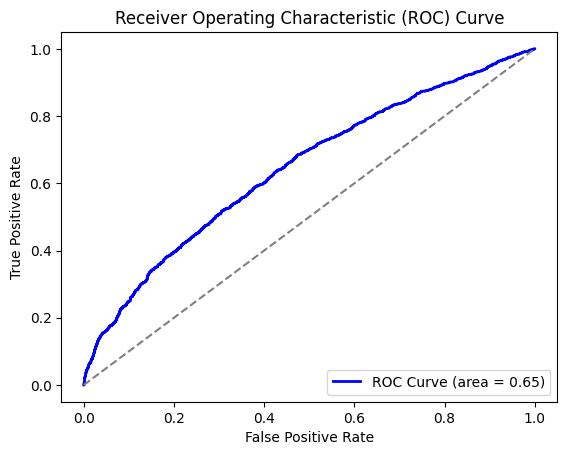

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.82      0.69      2658
           1       0.65      0.37      0.47      2342

    accuracy                           0.61      5000
   macro avg       0.62      0.60      0.58      5000
weighted avg       0.62      0.61      0.59      5000

Metrics on Test Data:
{'Accuracy': 0.6098, 'Confusion Matrix': array([[2191,  467],
       [1484,  858]]), 'ROC AUC': np.float64(0.6452803646436743), 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.60      0.82      0.69      2658\n           1       0.65      0.37      0.47      2342\n\n    accuracy                           0.61      5000\n   macro avg       0.62      0.60      0.58      5000\nweighted avg       0.62      0.61      0.59      5000\n'}


In [121]:
# Load the dataset
data_file = 'hospital_readmissions.csv'
data = pd.read_csv(data_file)

data['severity'] = data['time_in_hospital'] * (data['n_lab_procedures'] + 32 * data['n_procedures'])

# Define categorical and numerical columns
categorical_columns = ['age', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'glucose_test', 'A1Ctest', 'change', 'diabetes_med']
numerical_columns = ['time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency', 'severity']

# Initialize encoders and scaler
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
scaler = StandardScaler()

# Fit encoders and scaler on the entire data
one_hot_encoder.fit(data[categorical_columns])
scaler.fit(data[numerical_columns])

# Preprocess the data
X_train_data, X_test_data, y_train_data, y_test_data = preprocess_data(data, categorical_columns, numerical_columns, one_hot_encoder, scaler)

# Train the model using the training data
trained_model = train_model(X_train_data, y_train_data, epochs=40, learning_rate= 0.0003, layers=10)

# Test the model on the test dataset
metrics = test_model(trained_model, X_test_data, y_test_data)

# Print metrics
print("Metrics on Test Data:")
print(metrics)

In [122]:
def test_model_CV(model, X_test_data, y_test_data):
    """
    Evaluate the model on the specified test dataset.

    Args:
    - model: The trained neural network model instance.
    - X_test_data (ndarray): Testing feature data.
    - y_test_data (ndarray): Corresponding testing labels.

    Returns:
    - metrics (dict): Dictionary containing accuracy, confusion matrix, ROC AUC, and classification report.
    """
    # Set the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X_test_data, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y_test_data, dtype=torch.long).to(device)

    # Model predictions and probability extraction
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        _, predicted_labels = torch.max(outputs, 1)
        probabilities = nn.Softmax(dim=1)(outputs)[:, 1]  # Positive class probabilities

    # Convert predictions to numpy arrays and calculate evaluation metrics
    y_pred = predicted_labels.cpu().numpy()
    y_true = y_tensor.cpu().numpy()
    probabilities = probabilities.cpu().numpy()

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, probabilities)
    roc_auc = auc(fpr, tpr)

    # Classification Report
    report = classification_report(y_true, y_pred)

    # Metrics dictionary
    metrics = {
        "Accuracy": accuracy,
        "Confusion Matrix": conf_matrix,
        "ROC AUC": roc_auc,
        "Classification Report": report
    }

    return metrics

In [125]:
def cross_validate_model(data, categorical_columns, numerical_columns, encoder, scaler, n_splits=10, epochs=5, chunk_size=1000, learning_rate=0.005, activation='elu'):
    """
    Perform K-Fold Cross Validation on the model.

    Args:
    - data (DataFrame): The input data to preprocess.
    - categorical_columns (list): List of categorical column names.
    - numerical_columns (list): List of numerical column names.
    - encoder (OneHotEncoder): Fitted OneHotEncoder instance.
    - scaler (StandardScaler): Fitted StandardScaler instance.
    - n_splits (int): Number of folds for cross-validation.
    - epochs (int): Number of training epochs.
    - chunk_size (int): Size of data chunks for batch processing.
    - learning_rate (float): Learning rate for the optimizer.
    - activation (str): Activation function to use in the model.

    Returns:
    - results (dict): Dictionary containing average accuracy and metrics across folds.
    """
    # Prepare for cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracies = []
    confusion_matrices = []
    roc_aucs = []

    for train_index, test_index in kf.split(data):
        train_data, test_data = data.iloc[train_index], data.iloc[test_index]

        # Preprocess training and testing data
        X_train, X_test, y_train, y_test = preprocess_data(train_data, categorical_columns, numerical_columns, encoder, scaler)

        # Train the model
        model = train_model(X_train, y_train, epochs=epochs, chunk_size=chunk_size, learning_rate=learning_rate, activation=activation, layers = 10, log = False)

        # Test the model
        metrics = test_model_CV(model, X_test, y_test)

        # Collect metrics
        accuracies.append(metrics["Accuracy"])
        confusion_matrices.append(metrics["Confusion Matrix"])
        roc_aucs.append(metrics["ROC AUC"])

    # Calculate average metrics
    average_accuracy = np.mean(accuracies)
    average_confusion_matrix = np.mean(confusion_matrices, axis=0)
    average_roc_auc = np.mean(roc_aucs)

    results = {
        "Average Accuracy": average_accuracy,
        "Average Confusion Matrix": average_confusion_matrix,
        "Average ROC AUC": average_roc_auc
    }

    return results

In [ ]:
# Perform 10-fold cross-validation
results = cross_validate_model(
    data,
    categorical_columns,
    numerical_columns,
    one_hot_encoder,
    scaler,
    n_splits=10,
    epochs=50,
    chunk_size=1000,
    learning_rate=0.005,
    activation='elu'
)

# Print the results
print("Cross-Validation Results:")
print(f"Average Accuracy: {results['Average Accuracy'] * 100:.2f}%")
print("Average Confusion Matrix:")
print(results['Average Confusion Matrix'])
print(f"Average ROC AUC: {results['Average ROC AUC']:.2f}")